**La idea es probar los modelos de clasificación de Scikit-Learn en un dataset propio.**

En primer lugar vamos a importar el data set que se llama *`"fases_LRO_150_100-ABCDEFGH_100w.TXT"`*. Este dataset se generó a partir de una simulación de Monte Carlo en el conjunto semi-grand canónico. Refleja el estado de orden y el magnetismo presente para aleaciones de Cu-Al-Mn a distintas temperaturas y composiciones. La simulación muestra la existencia de un gap de miscibilidad en la región con 25% at. de Al entre dos fases para- y ferro-magnéticas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = '/content/fases_LRO_150_100-ABCDEFGH_100w.TXT'
df = pd.read_csv(file, sep=' ')

Veamos la información dentro del dataset.

In [2]:
df.columns

Index(['temperatura', 'mu_cu', 'mu_al', 'x_cu_mean', 'x_cu_std',
       'x_mn_up_mean', 'x_mn_up_std', 'x_mn_down_mean', 'x_mn_down_std',
       'x_al_mean', 'x_al_std', 'y_cu_mean', 'y_cu_std', 'y_mn_up_mean',
       'y_mn_up_std', 'y_mn_down_mean', 'y_mn_down_std', 'y_al_mean',
       'y_al_std', 'z_cu_mean', 'z_cu_std', 'z_mn_up_mean', 'z_mn_up_std',
       'z_mn_down_mean', 'z_mn_down_std', 'z_al_mean', 'z_al_std',
       'magnetizacion_mean', 'magnetizacion_std', 'delta_e_q_mean',
       'delta_e_q_std', 'delta_e_m_mean', 'delta_e_m_std', 'delta_e_qm_mean',
       'delta_e_qm_mean.1', 'c_cu', 'c_mn', 'c_al', 'fase_magn'],
      dtype='object')

En este caso particular, las columnas que son relevantes para observar el gap de miscibilidad son las composiciones `['c_cu', 'c_mn', 'c_al']` y la fase `['fase_magn']`. Este dataset ya fue procesado, pero normalmente de una simulación obtendriamos las primeras 16 columnas sin saber la fase en que se encuentra cada aleación para una dada temperatura.

La columna `['fase_magn']` se construye a partir de la información de las columnas que hacen referencia a los parámetros x, y, z, y la magnetización.

Como hay mucha información innecesaria vamos a crear un nuevo data frame eligiendo solo algunas columnas que nos van a servir para el análisis. Luego separamos la columna `['fase_magn']` que es lo que queremos estimar con los modelos de Scikit-learn.

In [3]:
features = ['temperatura',
            'x_cu_mean',
            'x_mn_up_mean',
            'x_mn_down_mean',
            'x_al_mean',
            'y_cu_mean',
            'y_mn_up_mean',
            'y_mn_down_mean',
            'y_al_mean',
            'z_cu_mean',
            'z_mn_up_mean',
            'z_mn_down_mean',
            'z_al_mean',
            'magnetizacion_mean',
            'c_cu',
            'c_mn',
            'c_al',
            'fase_magn']

df_new = df[features]

X = df_new.drop('fase_magn', axis=1)
y = df['fase_magn']

Veamos cuales son las etiquetas dentro de nuestro dataset:

<Axes: >

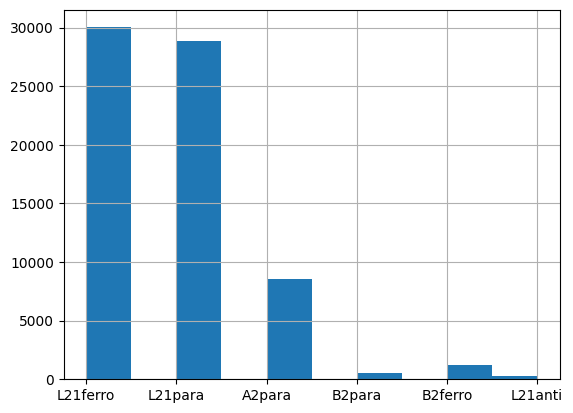

In [4]:
y.hist()

Como la distribución no es uniforme al momento de dividir nuestros datos para entrenamiento, y validación tenemos que tener cuidado que la misma distribución esté presente en estas divisiones.

In [7]:
from sklearn.model_selection import train_test_split

#test_size=0.3 usamos el 30% de los datos para el testeo y el 70% para el entrenamiento
#stratify=y repite la distribucion de y en y_train e y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

Veamos como quedaron estas distribuciones.

<Axes: >

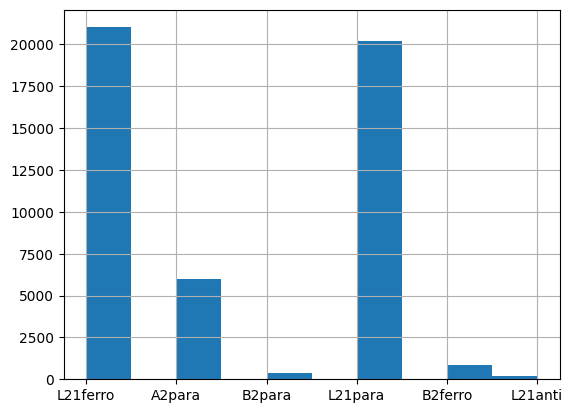

In [8]:
y_train.hist()

<Axes: >

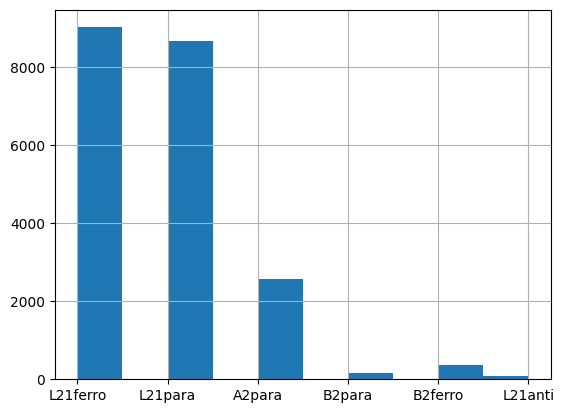

In [9]:
y_test.hist()

Como lo que queremos hacer es analizar distintos modelos sobre los mismos datos vamos a crear una función que reciba el nombre de un modelo, los datos y devuelva una predicción junto con valores sobre la precisión

In [10]:
def test_classifier(name, classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    print(f"\n--- Testing {name} ---")
    print(f"Entrenando {name}...")
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    print(f"\nEvaluando el modelo {name}:")
    print("Resultados del entrenamiento:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\nMatriz de Confusion:")
    print(confusion_matrix(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nPrecisión de {name}: {accuracy:.4f}")
    print(f"{name} Listo el pollo!")
    print("-" * 50) # Separator for readability

    return classifier, accuracy # Return the trained classifier and accuracy

Para visualizar los distintos modelos vamos a graficar el diagrama de fase correspondiente a la línea de composición con 25% at. de Al para los resultados predecidos y los verdaderos.

In [11]:
def plot_binary(X_test, y_test, y_pred, name):
    marker = {'B2ferro': '^',
              'B2para': 's',
              'B2anti': 'D',
              'A2ferro': '^',
              'A2para': 's',
              'A2anti': 'D',
              'L21ferro': '^',
              'L21para': 's',
              'L21anti': 'D'}

    color = {'B2ferro': 'r',
             'B2para': 'r',
             'B2anti': 'r',
             'A2ferro': 'y',
             'A2para': 'y',
             'A2anti': 'y',
             'L21ferro': 'b',
             'L21para': 'orange',
             'L21anti': 'b'}

    df_true = X_test.copy()
    df_true['fase_magn'] = y_test

    df_pred = X_test.copy()
    df_pred['fase_magn'] = y_pred

    fig = plt.figure(figsize=(10.8, 4.8))
    #fig.subplots_adjust(left=0.075, right=0.85, wspace=0.3)

    ax1 = fig.add_subplot(1, 2, 1)

    ax1.set_title(f'Classifier: {name}')
    ax1.set_ylabel('Temperature [K]')
    ax1.set_xlabel(r'$at.\%$ Mn')
    ax1.set_xlim(0, 25)
    ax1.set_ylim(350, 800)

    ax2 = ax1.twiny()
    ax2.set_xlabel(r'$y$')
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    ax1.text(1, 760, r'$Cu_{3-y}AlMn_y$',
             bbox=dict(edgecolor='k', facecolor='w'),
             fontsize=15)
    #ax1.text(10, 450, r'$DO_3+L2_1$', fontsize=20)


    df_pred = df_pred[np.abs(df_pred['c_al'] - 25.0) < .5]

    for name, group in df_pred.groupby('fase_magn'):
        # Note that we have to shuffle the order.
        # So the column order is: right, left, bottom.
        p = group[['c_mn', 'temperatura']].values

        ax1.scatter(p[:,0], p[:,1], marker=marker[name], s=50,
                    edgecolors=color[name], facecolors='none',
                    linewidths=0.5)


    #ax1.legend(loc='upper right')

    ax3 = fig.add_subplot(1, 2, 2)

    ax3.set_title('Datos reales')
    ax3.set_ylabel('Temperature [K]')
    ax3.set_xlabel(r'$at.\%$ Mn')
    ax3.set_xlim(0, 25)
    ax3.set_ylim(350, 800)

    ax4 = ax3.twiny()
    ax4.set_xlabel(r'$y$')
    ax4.set_xlim(0, 1)
    ax4.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    #ax4.text(1, 760, r'$Cu_{3-y}AlMn_y$',
    #         bbox=dict(edgecolor='k', facecolor='w'),
    #         fontsize=15)
    #ax4.text(10, 450, r'$DO_3+L2_1$', fontsize=20)


    df_true = df_true[np.abs(df_true['c_al'] - 25.0) < .5]

    for name, group in df_true.groupby('fase_magn'):
        # Note that we have to shuffle the order.
        # So the column order is: right, left, bottom.
        p = group[['c_mn', 'temperatura']].values

        ax3.scatter(p[:,0], p[:,1], marker=marker[name], s=50,
                    edgecolors=color[name], facecolors='none',
                    linewidths=0.5)


    #ax3.legend(loc='upper right')

    plt.show()

Por ultimo vamos a crear un diccionario con los modelos que queremos evaluar, con parámetros por defecto, y vamos a entrenar a cada modelo con los datos que separamos anteriormente y a graficarlos en el diagrama de fase.


--- Testing Logistic Regression ---
Entrenando Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluando el modelo Logistic Regression:
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.96      1.00      0.98      2568
     B2ferro       0.00      0.00      0.00       377
      B2para       0.39      0.11      0.18       157
     L21anti       0.00      0.00      0.00        82
    L21ferro       0.96      1.00      0.98      9010
     L21para       0.98      0.99      0.99      8647

    accuracy                           0.97     20841
   macro avg       0.55      0.52      0.52     20841
weighted avg       0.94      0.97      0.95     20841


Matriz de Confusion:
[[2557    0    2    0    0    9]
 [   0    0    0    0  377    0]
 [  94    0   18    0    5   40]
 [   0    0    3    0    0   79]
 [   0    0    0    0 8984   26]
 [  23    0   23    0    1 8600]]

Presición de Logistic Regression: 0.9673
Logistic Regression Listo el pollo!
--------------------------------------------------


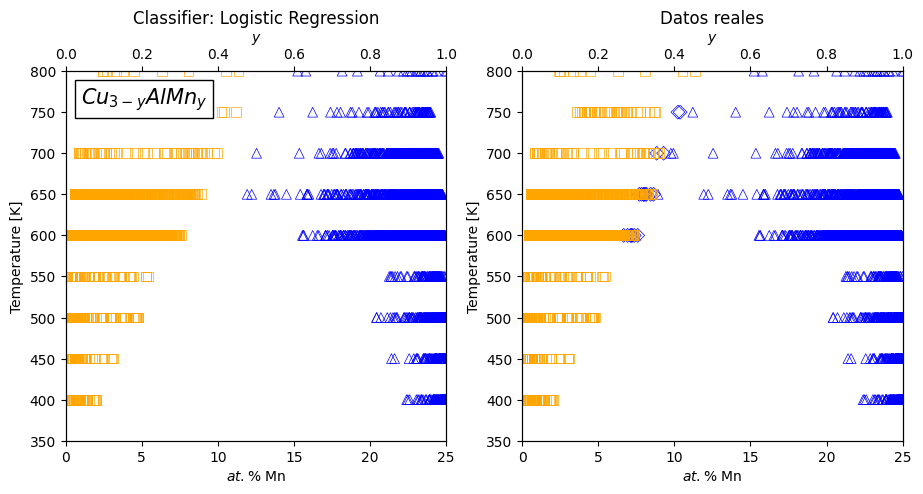


--- Testing Decision Tree ---
Entrenando Decision Tree...

Evaluando el modelo Decision Tree:
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.99      0.99      0.99      2568
     B2ferro       0.95      0.94      0.95       377
      B2para       0.73      0.76      0.74       157
     L21anti       0.64      0.71      0.67        82
    L21ferro       1.00      1.00      1.00      9010
     L21para       1.00      0.99      1.00      8647

    accuracy                           0.99     20841
   macro avg       0.88      0.90      0.89     20841
weighted avg       0.99      0.99      0.99     20841


Matriz de Confusion:
[[2530    0   32    0    0    6]
 [   0  355    0    0   22    0]
 [  30    1  119    2    0    5]
 [   0    0    0   58    4   20]
 [   0   17    0    5 8988    0]
 [   4    0   13   25    2 8603]]

Presición de Decision Tree: 0.9910
Decision Tree Listo el pollo!
---------------------------------------------

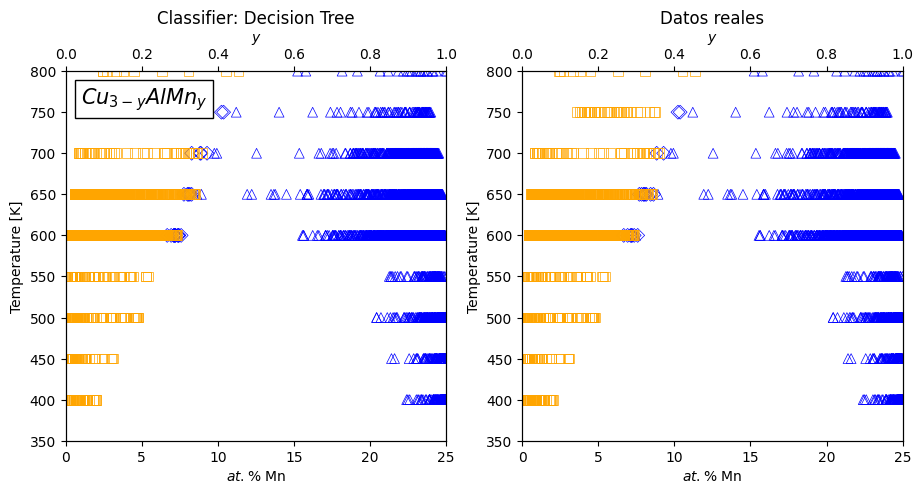


--- Testing Random Forest ---
Entrenando Random Forest...

Evaluando el modelo Random Forest:
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.99      0.99      0.99      2568
     B2ferro       0.97      0.95      0.96       377
      B2para       0.81      0.78      0.80       157
     L21anti       0.75      0.82      0.78        82
    L21ferro       1.00      1.00      1.00      9010
     L21para       1.00      1.00      1.00      8647

    accuracy                           0.99     20841
   macro avg       0.92      0.92      0.92     20841
weighted avg       0.99      0.99      0.99     20841


Matriz de Confusion:
[[2546    0   21    0    0    1]
 [   0  358    0    0   19    0]
 [  29    0  123    0    0    5]
 [   0    0    0   67    4   11]
 [   0   12    0    4 8994    0]
 [   4    0    8   18    0 8617]]

Presición de Random Forest: 0.9935
Random Forest Listo el pollo!
---------------------------------------------

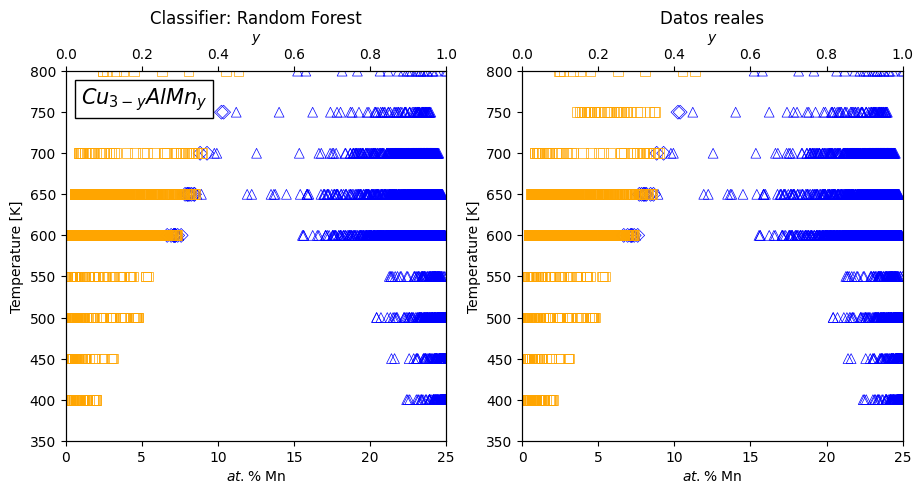


--- Testing Gradient Boosting ---
Entrenando Gradient Boosting...

Evaluando el modelo Gradient Boosting:
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.99      0.99      0.99      2568
     B2ferro       0.95      0.88      0.92       377
      B2para       0.84      0.76      0.80       157
     L21anti       0.66      0.82      0.73        82
    L21ferro       0.99      1.00      1.00      9010
     L21para       1.00      1.00      1.00      8647

    accuracy                           0.99     20841
   macro avg       0.91      0.91      0.90     20841
weighted avg       0.99      0.99      0.99     20841


Matriz de Confusion:
[[2544    0   17    0    0    7]
 [   0  333    0    0   44    0]
 [  32    0  119    0    0    6]
 [   0    0    0   67    6    9]
 [   0   16    0    9 8985    0]
 [   6    0    6   25    0 8610]]

Presición de Gradient Boosting: 0.9912
Gradient Boosting Listo el pollo!
-------------------------

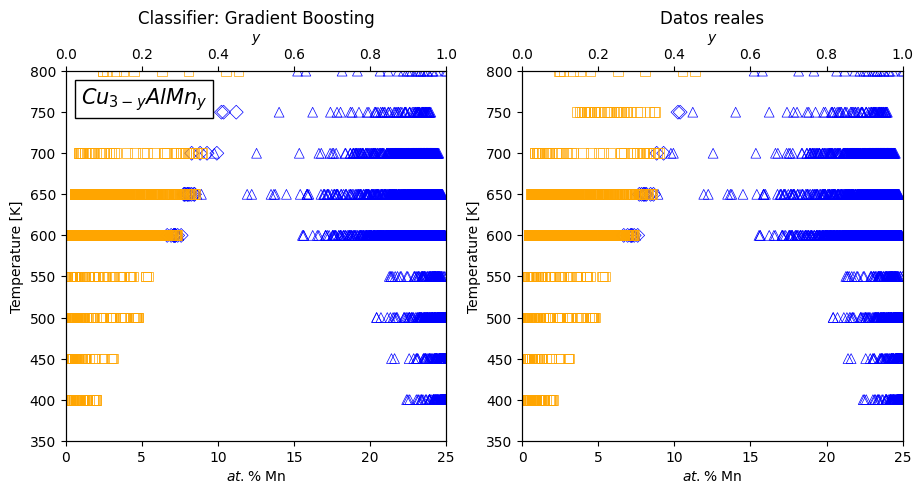


--- Testing Support Vector Machine (SVC) ---
Entrenando Support Vector Machine (SVC)...

Evaluando el modelo Support Vector Machine (SVC):
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.95      1.00      0.97      2568
     B2ferro       0.00      0.00      0.00       377
      B2para       0.00      0.00      0.00       157
     L21anti       0.00      0.00      0.00        82
    L21ferro       0.96      1.00      0.98      9010
     L21para       0.98      1.00      0.99      8647

    accuracy                           0.97     20841
   macro avg       0.48      0.50      0.49     20841
weighted avg       0.94      0.97      0.95     20841


Matriz de Confusion:
[[2564    0    0    0    0    4]
 [   0    0    0    0  377    0]
 [ 116    0    0    0    0   41]
 [   0    0    0    0    0   82]
 [   0    0    0    0 8972   38]
 [  24    0    0    0    0 8623]]

Presición de Support Vector Machine (SVC): 0.9673
Support Vector 

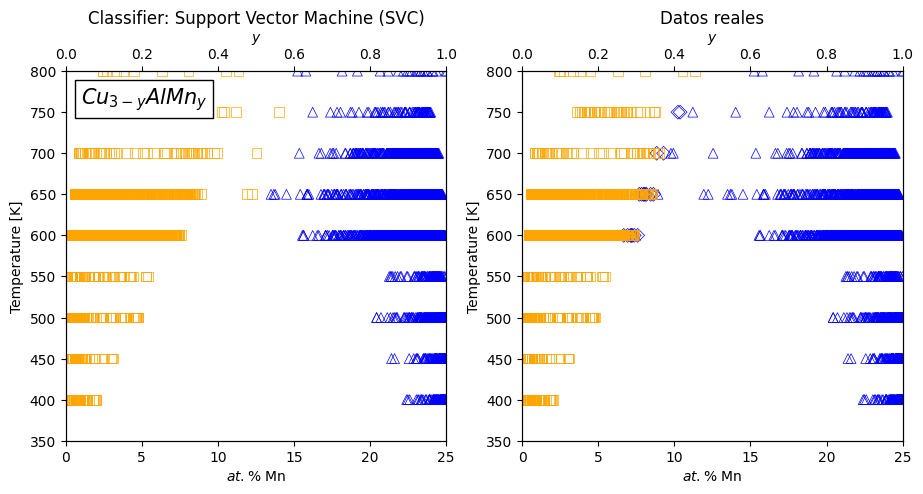


--- Testing K-Nearest Neighbors (KNN) ---
Entrenando K-Nearest Neighbors (KNN)...

Evaluando el modelo K-Nearest Neighbors (KNN):
Resultados del entrenamiento:
              precision    recall  f1-score   support

      A2para       0.96      0.99      0.98      2568
     B2ferro       0.85      0.77      0.81       377
      B2para       0.70      0.46      0.55       157
     L21anti       0.46      0.26      0.33        82
    L21ferro       0.99      0.99      0.99      9010
     L21para       0.99      0.99      0.99      8647

    accuracy                           0.98     20841
   macro avg       0.83      0.74      0.78     20841
weighted avg       0.98      0.98      0.98     20841


Matriz de Confusion:
[[2552    0   15    0    0    1]
 [   0  292    0    0   85    0]
 [  78    0   72    0    0    7]
 [   0    0    0   21    3   58]
 [   0   50    0    7 8943   10]
 [  20    0   16   18    3 8590]]

Presición de K-Nearest Neighbors (KNN): 0.9822
K-Nearest Neighbors (KNN) L

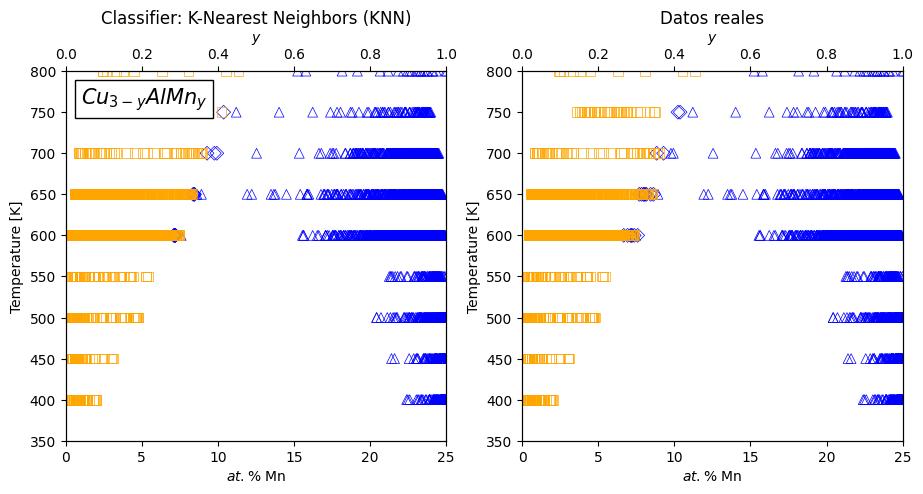


--- Resumen de los distintos Classifiers ---
Logistic Regression: 0.9673
Decision Tree: 0.9910
Random Forest: 0.9935
Gradient Boosting: 0.9912
Support Vector Machine (SVC): 0.9673
K-Nearest Neighbors (KNN): 0.9822


In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=400),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100,
                                                    random_state=42),
    "Support Vector Machine (SVC)": SVC(random_state=42, probability=True),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, classifier_model in classifiers.items():
    trained_classifier, accuracy = test_classifier(name, classifier_model,
                                                   X_train, y_train,
                                                   X_test, y_test)
    results[name] = accuracy

    # Predicciones para graficar
    y_pred_plot = trained_classifier.predict(X_test)

    plot_binary(X_test, y_test, y_pred_plot, name)


print("\n--- Resumen de los distintos Classifiers ---")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")